# Load data
We had to use a Python file to pull the catalog of sites from GASpy because NERSC's Jupyter seems to have poor connection to MongoDB. We saved the sites and load them again here.

In [1]:
import pickle


with open('./synthesized/sites_by_mpid.pkl', 'rb') as file_handle:
    sites_by_mpid = pickle.load(file_handle)

In [2]:
catalog_docs = [doc for docs in sites_by_mpid.values() for doc in docs]

# Showing initial landscape

/global/homes/k/ktran/miniconda3/envs/gaspy/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


1146.0


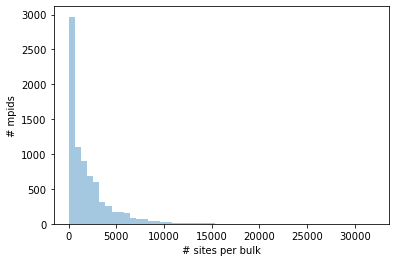

In [3]:
import numpy as np
import seaborn as sns


counts_by_mpid = {mpid: len(sites) for mpid, sites in sites_by_mpid.items()}

ax = sns.distplot(list(counts_by_mpid.values()), kde=False)

_ = ax.set_xlabel('# sites per bulk')
_ = ax.set_ylabel('# mpids')

counts = np.array(list(counts_by_mpid.values()))
print(np.median(counts))

In [4]:
from collections import defaultdict
from tqdm.notebook import tqdm
from gaspy.gasdb import get_surface_from_doc


sites_by_surface = defaultdict(list)
for doc in tqdm(catalog_docs, unit_scale=True):
    surface = get_surface_from_doc(doc)
    sites_by_surface[surface].append(doc)

successfully loaded your custom FW_config.yaml!


22.0


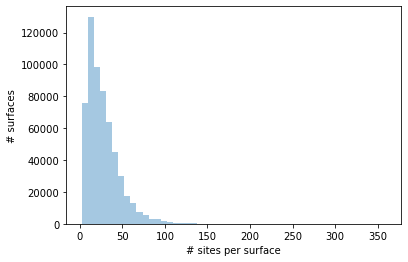

In [5]:
counts_by_surface = {surface: len(sites)
                     for surface, sites in sites_by_surface.items()}

ax = sns.distplot(list(counts_by_surface.values()), kde=False)

_ = ax.set_xlabel('# sites per surface')
_ = ax.set_ylabel('# surfaces')

counts = np.array(list(counts_by_surface.values()))
print(np.median(counts))


56.0


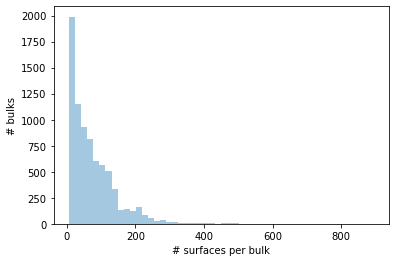

In [6]:
surfaces_by_bulk = defaultdict(list)
for surface, sites in tqdm(sites_by_surface.items(), unit_scale=True):
    bulk = surface[0]
    surfaces_by_bulk[bulk].append(surface)

surface_count_by_bulk = {bulk: len(surfaces)
                         for bulk, surfaces in surfaces_by_bulk.items()}

ax = sns.distplot(list(surface_count_by_bulk.values()), kde=False)

_ = ax.set_xlabel('# surfaces per bulk')
_ = ax.set_ylabel('# bulks')

counts = np.array(list(surface_count_by_bulk.values()))
print(np.median(counts))

# Selecting structures

In [7]:
n_sites = 20000
n_sites_per_surface = 20
n_surfaces_per_bulk = 5
n_sites_per_bulk = n_sites_per_surface * n_surfaces_per_bulk
n_bulks = int(n_sites / n_sites_per_bulk)

In [8]:
import random


samples = {}
sampling_mpids = list(counts_by_mpid.keys())
random.shuffle(sampling_mpids)

for mpid in tqdm(sampling_mpids):
    good_enough = True

    # Sample some surfaces
    surfaces = surfaces_by_bulk[mpid]
    try:
        sampled_surfaces = random.sample(surfaces, n_surfaces_per_bulk)

    # Don't bother with bulks that have too few surfaces
    except ValueError:
        continue

    # Sample some sites from each surface
    _sites_by_surface = {}
    for surface in sampled_surfaces:
        sites = sites_by_surface[surface]
        try:
            sampled_sites = random.sample(sites, n_sites_per_surface)

        # Don't bother with bulks whose surfaces have too few sites
        except ValueError:
            good_enough = False
            break

        # Allocate site samples by surface
        _sites_by_surface[surface] = sampled_sites

    # Make sure we stop if any of the surfaces did not have enough sites
    if good_enough is False:
        continue

    # Allocate the samples
    samples[mpid] = _sites_by_surface

    # Stop sampling
    if len(samples) >= n_bulks:
        break

# Synthesize & save energies

In [9]:
bulk_mean = 0.
bulk_std = 1.
surface_std = 0.3
site_std = 0.1

In [21]:
import os
from copy import deepcopy
from scipy.stats import norm
import ase.db
from gaspy.gasdb import get_mongo_collection
from gaspy.mongo import make_atoms_from_doc


# Initialize
db_name = './CO_synthesized/CO.db'
try:
    os.remove(db_name)
except FileNotFoundError:
    pass
db = ase.db.connect(db_name)

# Grab all the sites
mongo_ids = [site['mongo_id']
             for bulks in samples.values()
             for surfaces in bulks.values()
             for site in surfaces]
query = {'_id': {'$in': mongo_ids}}
projection = {'atoms': 1, 'calc': 1, 'results': 1}
with get_mongo_collection('catalog') as collection:
    all_docs = list(tqdm(collection.find(query, projection), desc='pulling docs'))
docs_by_id = {doc['_id']: doc for doc in all_docs}
    
# Make up an energy
for mpid, _samples in tqdm(samples.items(), desc='bulks'):
    sampled_bulk_mean = norm.rvs(loc=bulk_mean, scale=bulk_std)
    for surface, sites in tqdm(_samples.items(), desc='surfaces'):
        sampled_surface_mean = norm.rvs(loc=sampled_bulk_mean, scale=surface_std)
        for site in tqdm(sites, desc='sites'):
            sampled_energy = norm.rvs(loc=sampled_surface_mean, scale=site_std)

            # Make the atoms object
            doc = docs_by_id[site['mongo_id']]
            atoms = make_atoms_from_doc(doc)

            # Grab meta info
            miller = tuple(site['miller'])
            shift = round(site['shift'], 2)
            top = site['top']
            data = {'adsorption_energy': sampled_energy,
                    'mpid': mpid,
                    'miller': miller,
                    'shift': shift,
                    'top': top}

            # Write to the DB
            db.write(atoms, data=data)